**Dataset Analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


data = pd.read_csv('/content/btc.csv')
print("Dataset loaded. Total records:", data.shape[0])
data.head()


Dataset loaded. Total records: 2713


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], color='blue', label='Closing Price')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

NameError: name 'data' is not defined

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [ ]:
sequence_length = 60
X_train, y_train = [], []
for i in range(sequence_length, len(scaled_data)):
    X_train.append(scaled_data[i-sequence_length:i, 0])
    y_train.append(scaled_data[i, 0])

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("Data reshaped for LSTM:", X_train.shape)

Data reshaped for LSTM: (2653, 60, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
print("LSTM model compiled.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM model compiled.


In [ ]:
epochs = 15
batch_size = 125
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
print("Model training completed.")

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.5567e-04 - val_loss: 0.0097
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.9091e-04 - val_loss: 0.0027
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4456e-04 - val_loss: 0.0022
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.4597e-04 - val_loss: 0.0023
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.8488e-04 - val_loss: 0.0070
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0031e-04 - val_loss: 0.0021
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.7441e-04 - val_loss: 0.0028
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8210e-04 - val_loss: 0.0015
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.6288e-04 - val_loss: 0.0020
Epoch 12/50
75/75 ━━━━━━━━━━

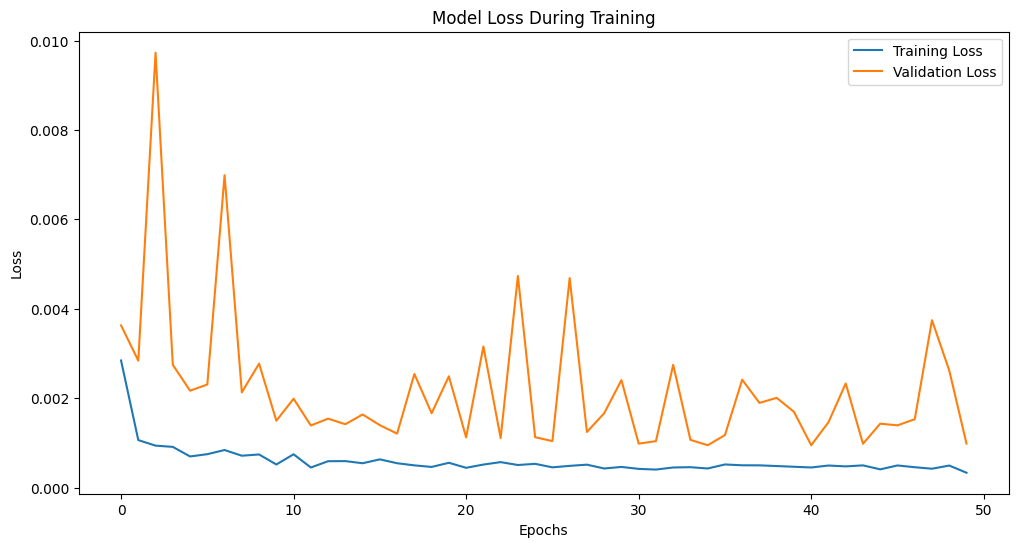

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# training plot

In [ ]:
test_data = data[-sequence_length:]
inputs = scaler.transform(test_data['Close'].values.reshape(-1, 1))

In [ ]:
X_test, y_test = [], []
for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])

In [ ]:
if len(X_test) == 0:
    print("Error: X_test is empty. Check sequence_length or test data preparation.")
else:
    X_test = np.array(X_test)
    print("X_test shape before reshaping:", X_test.shape)
    try:
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        print("X_test reshaped for prediction:", X_test.shape)
    except IndexError:
        print("Error: Reshaping failed. Check dimensions of X_test.")

Error: X_test is empty. Check sequence_length or test data preparation.


In [ ]:
sequence_length = 40
test_data = data['Close'].values[-(sequence_length + 100):]
inputs = scaler.transform(test_data.reshape(-1, 1))
X_test = []
for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])
if len(X_test) == 0:
    print("Error: X_test is still empty. Check data range and sequence length.")
else:
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print("X_test prepared successfully:", X_test.shape)

X_test prepared successfully: (100, 60, 1)


In [ ]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


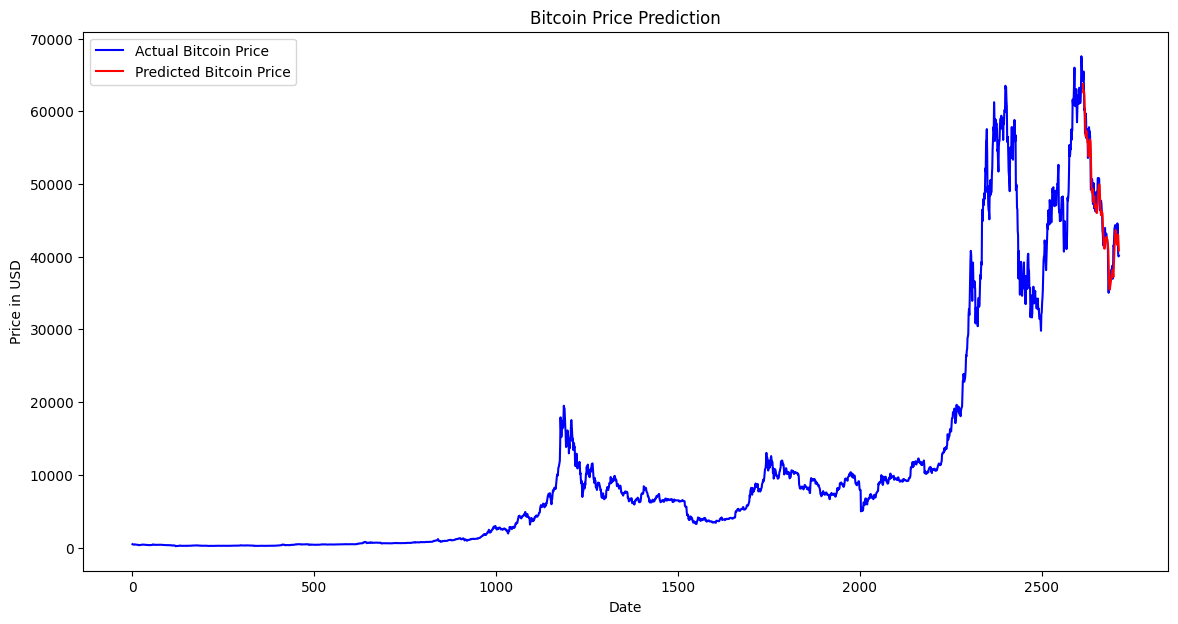

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'].values, color='blue', label='Actual Bitcoin Price')
plt.plot(range(len(data) - len(predicted_prices), len(data)), predicted_prices, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()